Student name: Aleksi Pikkarainen <br>
Student number 519153 <br>
February 5th 2024  <br>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2024

### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b> <br>

<b> Instructions: </b> 

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score (using sklearn.preprocessing.StandardScaler is advised).
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Explain your code by adding detailed comments. 
    - Only provide code that is relevant to the exercise.
    - Please submit your solution as a Jupyter Notebook (.ipynb) and as a PDF file. Ensure to include your full name in the filename.     
    - Submit to moodle your solution on ** Wednesday 7 of February ** at the latest.
  
<b>Please follow the instructions and note that you are expected to submit your individual solution.<br>
Identical or overly similar submissions will result in the exercise being marked as failed.
</b>

## Import libraries

In [1]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import zscore
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
from sklearn import neighbors
from lifelines.utils import concordance_index

## Read and visualize the dataset

In [2]:
# In this cell read the file Water_data.csv
# Print the dataset dimesions (i.e. number of rows and columns)
# Print the first 5 rows of the dataset
data = pd.read_csv("water_data.csv")
print(data.shape, data.head)

(268, 6) <bound method NDFrame.head of       Mod1  Mod2    Mod3  c_total      Cd      Pb
0     9945   119   72335        0     0.0     0.0
1     9596   119  110542        0     0.0     0.0
2    10812   120   98594        0     0.0     0.0
3    10786   117   82977        0     0.0     0.0
4    10566   108  136416       14     0.0    14.0
..     ...   ...     ...      ...     ...     ...
263  22530  1443    6310     5000  4000.0  1000.0
264  23331  4241  140303     5000  5000.0     0.0
265  22633  4527  127464     5000  5000.0     0.0
266  22655  4467  144188     5000  5000.0     0.0
267  23115  4286  149312     5000  5000.0     0.0

[268 rows x 6 columns]>


## Standardization of the dataset

In [3]:
# In this cell, standardize the dataset features by removing the mean and scaling to unit variance. 
# In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
# Print the 5 first samples (i.e. rows) of the scaled dataset
features = ["Mod1", "Mod2", "Mod3"]
labels = ["c_total", "Cd", "Pb"]
data[features] = data[features].apply(zscore)
print(data.head)

<bound method NDFrame.head of          Mod1      Mod2      Mod3  c_total      Cd      Pb
0   -0.972283 -0.670482 -0.358179        0     0.0     0.0
1   -0.975878 -0.670482  0.259488        0     0.0     0.0
2   -0.963351 -0.670394  0.066333        0     0.0     0.0
3   -0.963619 -0.670657 -0.186137        0     0.0     0.0
4   -0.965885 -0.671447  0.677776       14     0.0    14.0
..        ...       ...       ...      ...     ...     ...
263 -0.842630 -0.554263 -1.425562     5000  4000.0  1000.0
264 -0.834378 -0.308659  0.740615     5000  5000.0     0.0
265 -0.841569 -0.283555  0.533055     5000  5000.0     0.0
266 -0.841343 -0.288821  0.803421     5000  5000.0     0.0
267 -0.836604 -0.304709  0.886257     5000  5000.0     0.0

[268 rows x 6 columns]>


## C-index code 

In [4]:
# In this cell, implement the C-index function. You may use the implementation from the first exercise.
def cindex(y, yp):
    """Returns C-index between true labels and predicted labels""" 
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
                    
    #Dividing by zero was not an issue last time so I had to modify this part.
    if n != 0:
        return h_num/n
    else: 
        return 0.0

In [5]:
# Test the cindex function with following values
true_labels = np.array([-1, 1, 1, -1, 1])
predictions = np.array([0.60, 0.80, 0.75, 0.75, 0.70])
cindx = cindex(true_labels, predictions)
print(cindx) #For this example, a correct C-index implementation will result in 0.75

0.75


## Leave-One-Out cross-validation
In the following cell, write and execute your code for Leave-One-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-One-Out C-index for c_total, Cd and Pb for each k value.

In [6]:

# our k-values which we will do our k-NN with
k_values = (1,3,5,7)

# initializiing our Leave-One-Out Cross Validation
loocv = LeaveOneOut()

# Taking our features and labels and modifying them for easier data extraction
inputs = data[features]
outputs = data[labels]
X = inputs.to_numpy()
y = outputs.to_numpy()

# Empty array to score our results in for plotting
loocv_scores = []

# iterating with our k values
for k in k_values:
    
    # empty arrays to save our test labels
    c_total_test = []
    cd_test = []
    pb_test = []

    # empty arrays to save our predicted labels
    c_total_pred = []
    cd_pred = []
    pb_pred = []

    # performing the standard loocv split for our data
    for train, test in loocv.split(data):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        # initializing the model
        knn = neighbors.KNeighborsRegressor(n_neighbors=k)
        
        # fitting our model
        knn.fit(X_train, y_train)
        
        # predicting on our test data
        pred_labels = knn.predict(X_test)
        
        # adding our test labels by column to their arrays
        c_total_test.append(y_test[0][0])
        cd_test.append(y_test[0][1])
        pb_test.append(y_test[0][2])
        
        # adding our predicted labels by column to  their arrays
        c_total_pred.append(pred_labels[0][0])
        cd_pred.append(pred_labels[0][1])
        pb_pred.append(pred_labels[0][2])
        
    # final print 
    print(f"C-scores for k value of {k}: C_total = {cindex(c_total_test, c_total_pred):.3f}, Cd = {cindex(cd_test, cd_pred):.3f}, Pb = {cindex(pb_test, pb_pred):.3f}")  
    
    # this is not optimal but to save time I'll just do it like this
    loocv_scores.append([k,cindex(c_total_test, c_total_pred),cindex(cd_test, cd_pred),cindex(pb_test, pb_pred)])
        
        

C-scores for k value of 1: C_total = 0.908, Cd = 0.914, Pb = 0.880
C-scores for k value of 3: C_total = 0.920, Cd = 0.912, Pb = 0.885
C-scores for k value of 5: C_total = 0.896, Cd = 0.866, Pb = 0.861
C-scores for k value of 7: C_total = 0.884, Cd = 0.832, Pb = 0.841


## Leave-Replicas-Out cross-validation

In the following cell, write and execute your code for Leave-Replicas-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-Replicas-Out C-index for c_total, Cd and Pb for each k value.

In [7]:
#First we need to do some grouping

# Create a column with replicas by the metal concentrations
d = data.duplicated(subset=labels)

# Add the replicas as a column to our original data
data["groups"] = d

# Modifying this column so, that the replicas all have a same integer as an identifier
counter = 0
for i, j in enumerate(data["groups"]):
    if j == False:
        counter += 1
        data.loc[i, "groups"] = counter
    else:
        data.loc[i, "groups"] = counter
        
# our k-values which we will do our k-NN with
k_values = (1,3,5,7)

# initializiing our Leave-One-Out Cross Validation
logocv = LeaveOneGroupOut()

# Taking our features and labels and modifying them for easier data extraction
inputs = data[features]
outputs = data[labels]
groups = data["groups"]
X = inputs.to_numpy()
y = outputs.to_numpy()
g = groups.to_numpy()

# Empty array to score our results in for plotting
logocv_scores = []

# iterating with our k values
for k in k_values:
    
    # empty arrays to save our test labels
    c_total_test = []
    cd_test = []
    pb_test = []

    # empty arrays to save our predicted labels
    c_total_pred = []
    cd_pred = []
    pb_pred = []

    # performing the standard logocv split for our data
    for train, test in logocv.split(X, y, g):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        # initializing the model
        knn = neighbors.KNeighborsRegressor(n_neighbors=k)
        
        # fitting our model
        knn.fit(X_train, y_train)
        
        # predicting on our test data
        pred_labels = knn.predict(X_test)
        
        # adding our test labels by column to their arrays
        c_total_test.append(y_test[0][0])
        cd_test.append(y_test[0][1])
        pb_test.append(y_test[0][2])
        
        # adding our predicted labels by column to  their arrays
        c_total_pred.append(pred_labels[0][0])
        cd_pred.append(pred_labels[0][1])
        pb_pred.append(pred_labels[0][2])
        
    # final print 
    print(f"C-scores for k value of {k}: C_total = {cindex(c_total_test, c_total_pred):.3f}, Cd = {cindex(cd_test, cd_pred):.3f}, Pb = {cindex(pb_test, pb_pred):.3f}") 
    
    
    # this is not optimal but to save time I'll just do it like this
    logocv_scores.append([k,cindex(c_total_test, c_total_pred),cindex(cd_test, cd_pred),cindex(pb_test, pb_pred)])

C-scores for k value of 1: C_total = 0.843, Cd = 0.757, Pb = 0.740
C-scores for k value of 3: C_total = 0.836, Cd = 0.731, Pb = 0.770
C-scores for k value of 5: C_total = 0.820, Cd = 0.723, Pb = 0.759
C-scores for k value of 7: C_total = 0.831, Cd = 0.758, Pb = 0.754


## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

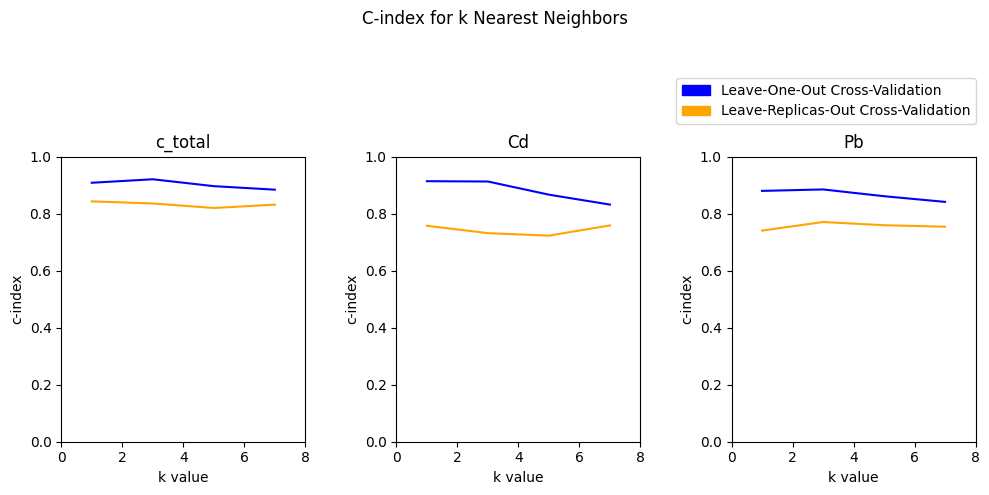

In [8]:
# Initialize subplots
fig, axes = plt.subplots(1,3, figsize=(10,5))
plot_titles = labels

# Transpose our scores to fit better in the plots
loocv_trans = list(map(list, zip(*loocv_scores)))
logocv_trans = list(map(list, zip(*logocv_scores)))

for j in range(3):
    axes[j].plot(loocv_trans[0], loocv_trans[j+1], label="leave-one-out", color="blue")
    axes[j].plot(logocv_trans[0], logocv_trans[j+1], label="leave-one-group-out", color="orange")
    axes[j].set_title(plot_titles[j])
    axes[j].set_ylim(0,1)
    axes[j].set_xlim(0,8)
    axes[j].set_xlabel("k value")
    axes[j].set_ylabel("c-index")

fig.suptitle("C-index for k Nearest Neighbors")
loocv = mpatches.Patch(color="blue", label="Leave-One-Out Cross-Validation")
logocv = mpatches.Patch(color="orange", label = "Leave-Replicas-Out Cross-Validation")
plt.legend(handles=[loocv, logocv], loc=1, bbox_to_anchor=(1.03, 1.3))
plt.tight_layout()


## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation method had more optimistic results? 
- Explain the reason for the optimistic results produced by the cross-validation method.
- Which cross-validation method generalized better on unseen data? Why?

In [13]:
#In this cell write your answers to the questions.

# The Leave-One-Out method had better results altogether.

# I think that with the loocv we got more cross-validation subsets which helped the method to achieve better results. We also saw how even if different features came to the same conclusion with the labels multiple times,
#it gave the k-NN more data to do predictions with.
# Also I think that if we look at the graphs, the LOOCV seems to lose accuracy as k increases which might make the LROCV better with larger k-values that we didn't explore in this exercise.

#Since there were almost 70 different groups, the LOOCV performed better. There were no strong groups so that helped with this data. Had there been fewer of the groups, the LROCV could have worked better to capture better estimates on the groups.